In [1]:
#import latex font to matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import squidpy as sq
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
import copy
import numpy as np
import pandas as pd

matplotlib.rcParams['text.usetex'] = False
plt.style.use('ggplot')

sns.set_style("whitegrid", {'axes.grid' : False})

fs = 10

Import top5k variable genes

In [2]:
hvg = pd.read_csv("/sdd/marco_sma/data/ekvall/marco_sma/hvfAll.txt")
hvg = hvg.values.flatten()

Import Visium data

In [3]:
visium_path = "/sdd/marco_sma/data/ekvall/marco_sma/RAW/visium/V11T17-101"
visium_data = dict()
import squidpy as sq
import os
for file in os.listdir(visium_path):
    if file == "qc":
        continue
    visium_data[f"{file}"] = dict()
    visium_data[f"{file}"]["expression"] = sq.read.visium(visium_path + f"/{file}/output_data/{file}/outs")
   

/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Import SMA

In [4]:
sma_paths = ["/sdd/marco_sma/data/ekvall/marco_sma/RAW/V11L12-109/", "/sdd/marco_sma/data/ekvall/marco_sma/RAW/V11L12-038/"]
sma_data = dict()
for sma_path in sma_paths:
    for file in os.listdir(sma_path):
        if file == "qc":
            continue
        sma_data[f"{file}"] = dict()
        sma_data[f"{file}"]["expression"] = sq.read.visium(sma_path + f"/{file}/output_data/{file}_RNA/outs")
        

/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/ekvall/anaconda3/envs/eggplant2/lib/python3.9/site-packages/anndata/_core/

Preprocess data: pick variable genes and log it with base 2

In [5]:
base = 10
for sample in visium_data.keys():
    expression = visium_data[sample]['expression']
    #expression = expression[:,expression.var.gene_ids.index.isin(hvg)]
    #sc.pp.log1p(expression, base=base)
    visium_data[sample]['expression'] = expression


for sample in sma_data.keys():
    expression = sma_data[sample]['expression']
    #expression = expression[:,expression.var.gene_ids.index.isin(hvg)]
    #sc.pp.log1p(expression, base=base)
    sma_data[sample]['expression'] = expression

Only use sample B1 V11T17-101_B1 of visium

In [6]:
expression_visium = visium_data['V11T17-101_B1']['expression']
expression_visium = np.log10(expression_visium.X.toarray().sum(0) + 1) if base == 10 else np.log2(expression_visium.X.toarray().sum(0) + 1)

Map SMA sample name to matrix names

In [7]:
for sma_sample in sma_data.keys():
    expression_sma = sma_data[sma_sample]['expression']
    sma_data[sma_sample]['expression'] = expression_sma.X.toarray()

In [8]:
filename = ['V11L12-109_C1', 'V11L12-109_A1', 'V11L12-109_B1', 'V11L12-109_D1', 'V11L12-038_B1', 'V11L12-038_C1', 'V11L12-038_A1', 'V11L12-038_D1']
name = ['FMP10.4', 'FMP10.1', 'FMP10.3', 'iCtrlFMP10', 'DHB2', 'iCtrlnM', 'DHB1', '9AA']

filename2name = dict(zip(filename, name))

In [9]:
sma_expression = dict()
for sma_key in sma_data:
    sma_expression[filename2name[sma_key]] = sma_data[sma_key]['expression']

Copy SMA, so we can have one dataset where we combine replicate

In [10]:
sma_expression_combined = copy.deepcopy(sma_expression)

Combine repliactes

In [11]:
""" sma_expression_combined['FMP10'] = np.concatenate([sma_expression_combined['FMP10.4'], sma_expression_combined['FMP10.1'], sma_expression_combined['FMP10.3']])
del sma_expression_combined['FMP10.4']
del sma_expression_combined['FMP10.1']
del sma_expression_combined['FMP10.3'] """

" sma_expression_combined['FMP10'] = np.concatenate([sma_expression_combined['FMP10.4'], sma_expression_combined['FMP10.1'], sma_expression_combined['FMP10.3']])\ndel sma_expression_combined['FMP10.4']\ndel sma_expression_combined['FMP10.1']\ndel sma_expression_combined['FMP10.3'] "

In [12]:
""" sma_expression_combined['DHB'] = np.concatenate([sma_expression_combined['DHB1'], sma_expression_combined['DHB2']])
del sma_expression_combined['DHB1']
del sma_expression_combined['DHB2']
 """

" sma_expression_combined['DHB'] = np.concatenate([sma_expression_combined['DHB1'], sma_expression_combined['DHB2']])\ndel sma_expression_combined['DHB1']\ndel sma_expression_combined['DHB2']\n "

Get mean expression for each sample

In [13]:
sma_expression = {k: np.log10(v.sum(0) + 1) if base == 10 else np.log2(v.sum(0) + 1) for k, v in sma_expression.items()}
sma_expression_combined = {k: np.log10(v.sum(0) + 1) if base == 10 else np.log2(v.sum(0) + 1) for k, v in sma_expression_combined.items()}

In [14]:
sma_expression_combined['FMP10'] = np.stack([sma_expression_combined['FMP10.4'], sma_expression_combined['FMP10.1'], sma_expression_combined['FMP10.3']]).mean(0)
del sma_expression_combined['FMP10.4']
del sma_expression_combined['FMP10.1']
del sma_expression_combined['FMP10.3']

In [15]:
sma_expression_combined['DHB'] = np.stack([sma_expression_combined['DHB1'], sma_expression_combined['DHB2']]).mean(0)
del sma_expression_combined['DHB1']
del sma_expression_combined['DHB2']

In [16]:
#set log2 threshold to +/-0.25
k = 0.25
#k = 1

Create lg2(expression) Vs. lg2(expression) for Visium vs SMA for all replicates

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

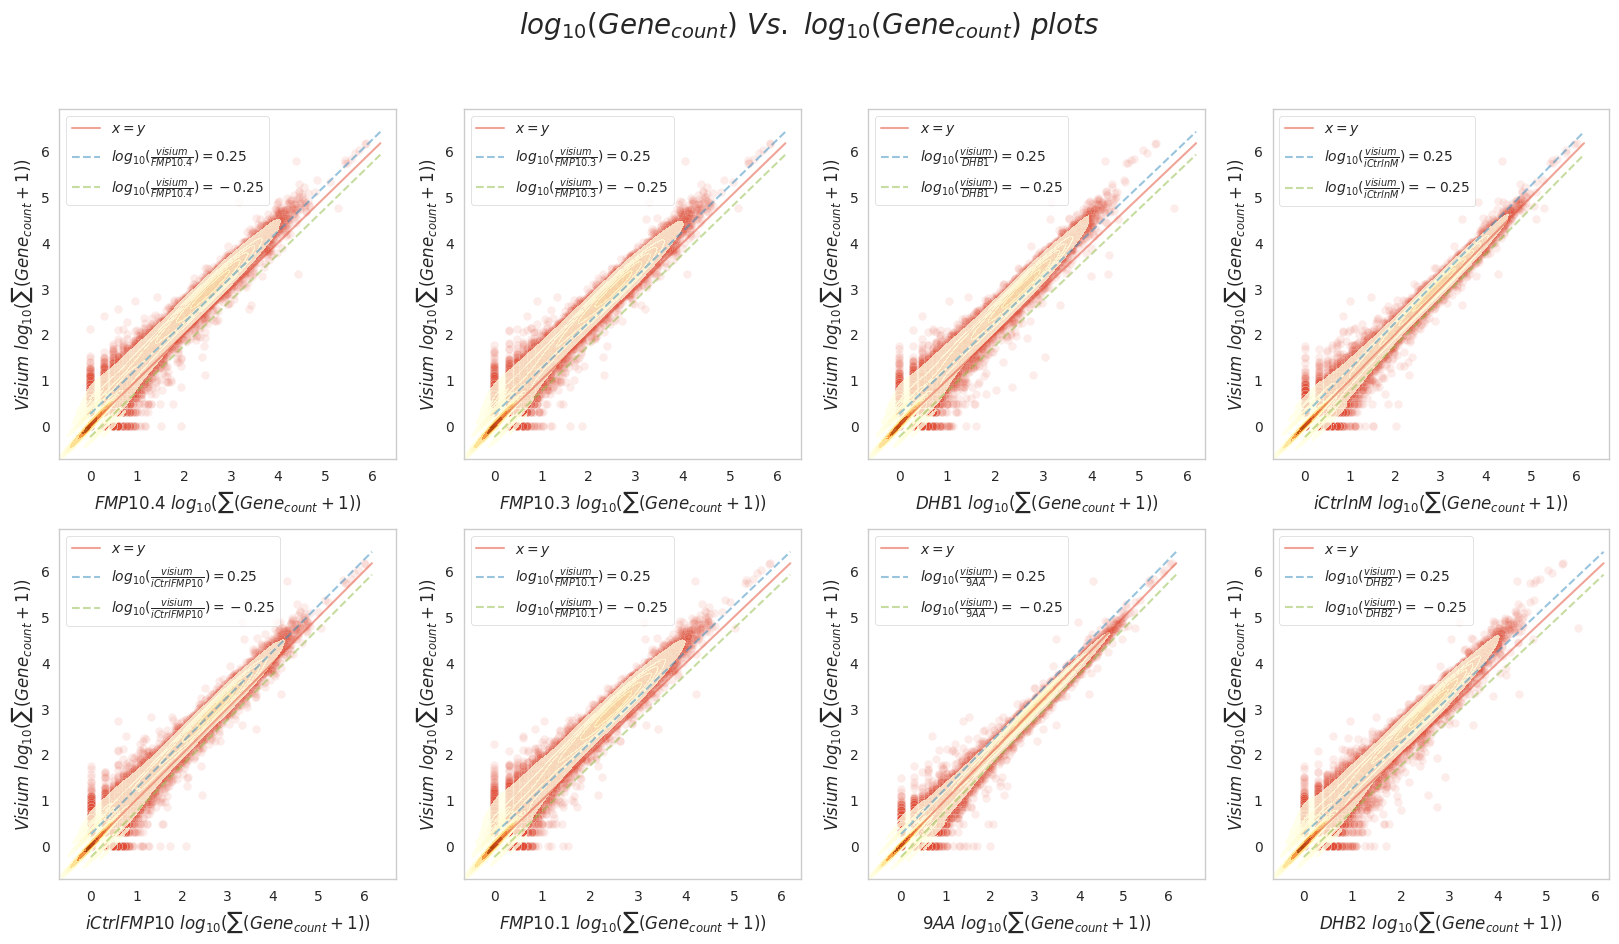

In [17]:
def getlgfold(x,k=0.25):
    return k + x

#plot 8 plots in a 2x4 grid
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(r'$log_{{{base}}}(Gene_{{count}})\ Vs.\ log_{{{base}}}(Gene_{{count}})\ plots$'.format(base=base), fontsize=20)

for i, sma_sample in enumerate(sma_expression.keys()):
    expression_sma = sma_expression[sma_sample]

    data = pd.DataFrame({
       r"$Visium\ log_{{{base}}}(\sum (Gene_{{count}} + 1))$".format(base=base): expression_visium,
        r"${sma_sample}\ log_{{{base}}}(\sum (Gene_{{count}} + 1))$".format(sma_sample=sma_sample, base=base): expression_sma
    })
    

    sns.scatterplot(x=r"${sma_sample}\ log_{{{base}}}(\sum (Gene_{{count}} + 1))$".format(sma_sample=sma_sample, base=base), 
    y=r"$Visium\ log_{{{base}}}(\sum (Gene_{{count}} + 1))$".format(base=base) ,data=data, ax=axs[i % 2, i // 2], alpha=.1, color='C0')

    #add sns density plot with yellow color
    sns.kdeplot(x=r"${sma_sample}\ log_{{{base}}}(\sum (Gene_{{count}} + 1))$".format(sma_sample=sma_sample, base=base),
    y=r"$Visium\ log_{{{base}}}(\sum (Gene_{{count}} + 1))$".format(base=base), data=data, ax=axs[i % 2, i // 2], fill=True, alpha=0.75, cmap="YlOrBr")

    
    #make a lineplot with hue help text
    x = min(min(expression_sma), min(expression_visium))
    y = max(max(expression_sma), max(expression_visium))
    sns.lineplot(
        x=[x,y], 
        y=[x,y], 
    color='C0', linestyle='-', linewidth=1.5, label=r'$x=y$', ax=axs[i % 2, i // 2], alpha=0.5)


    sns.lineplot(x=[x,y],y=[getlgfold(x,k), getlgfold(y,k)], color='C1', linestyle='--', linewidth=1.5, label=r'$log_{{{base}}}(\frac{{visium}}{{{sma_sample}}})={{{k}}}$'.format(base=base, sma_sample=sma_sample, k=k), ax=axs[i % 2, i // 2], alpha=0.5)
    sns.lineplot(x=[x,y], y=[getlgfold(x,-k), getlgfold(y,-k)], color='C5', linestyle='--', linewidth=1.5, label=r'$log_{{{base}}}(\frac{{visium}}{{{sma_sample}}})=-{{{k}}}$'.format(base=base, sma_sample=sma_sample, k=k), ax=axs[i % 2, i // 2], alpha=0.5)
    plt.legend()


plt.show()
#save figure as pdf
fig.savefig('visium_vs_sma_log2.pdf', bbox_inches='tight')

Create lg2(expression) Vs. lg2(expression) for Visium vs SMA for combined repliactes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


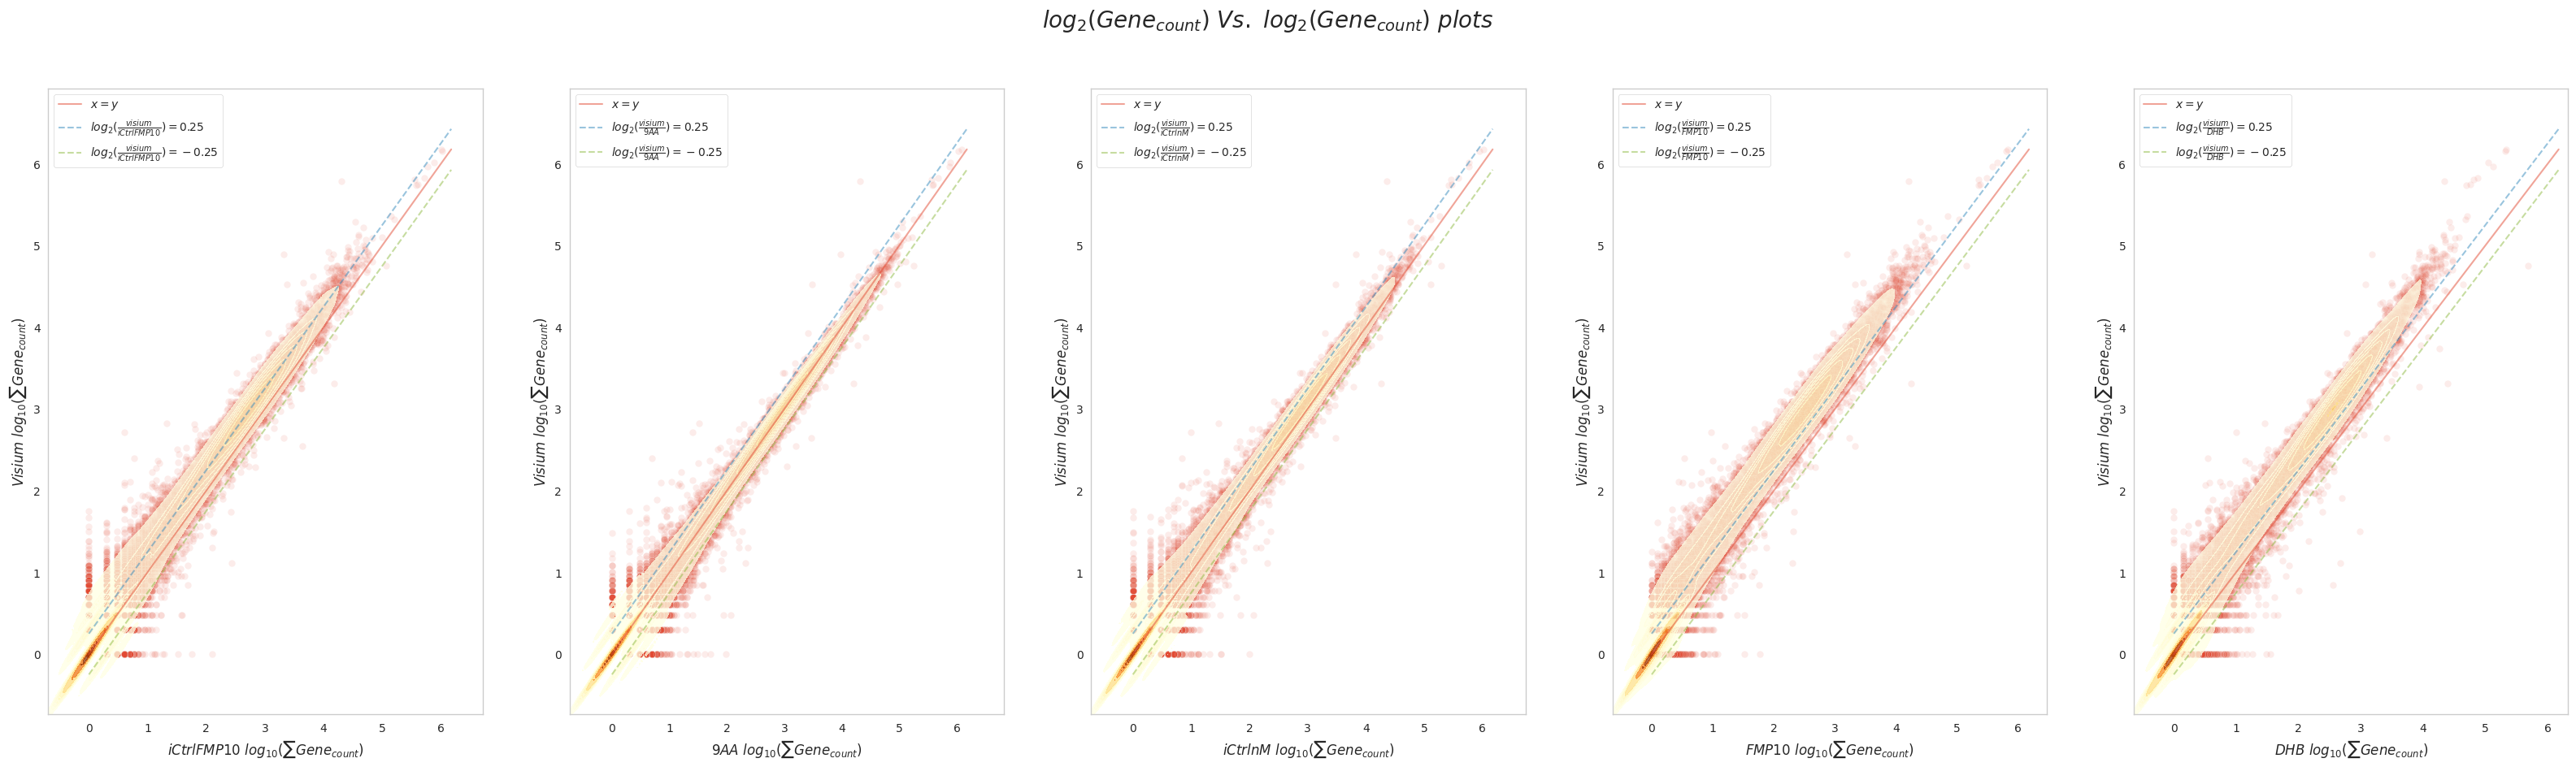

In [18]:
def getlgfold(x,k=0.25):
    return k + x

#plot 8 plots in a 2x4 grid
fig, axs = plt.subplots(1,5, figsize=(40, 10))
fig.suptitle(r'$log_{2}(Gene_{count})\ Vs.\ log_{2}(Gene_{count})\ plots$', fontsize=20)

for i, sma_sample in enumerate(sma_expression_combined.keys()):
    expression_sma = sma_expression_combined[sma_sample]

    data = pd.DataFrame({
       r"$Visium\ log_{{{base}}}(\sum Gene_{{count}})$".format(base=base): expression_visium,
        r"${sma_sample}\ log_{{{base}}}(\sum Gene_{{count}})$".format(sma_sample=sma_sample, base=base): expression_sma
    })


    sns.scatterplot(x=r"${sma_sample}\ log_{{{base}}}(\sum Gene_{{count}})$".format(sma_sample=sma_sample, base=base), 
    y=r"$Visium\ log_{{{base}}}(\sum Gene_{{count}})$".format(base=base) ,data=data, ax=axs[i], alpha=.1, color='C0')

    #add sns density plot with yellow color
    sns.kdeplot(x=r"${sma_sample}\ log_{{{base}}}(\sum Gene_{{count}})$".format(sma_sample=sma_sample, base=base),
    y=r"$Visium\ log_{{{base}}}(\sum Gene_{{count}})$".format(base=base), data=data, ax=axs[i], fill=True, alpha=0.75, cmap="YlOrBr")
    

   
    #make a lineplot with hue help text
    x = min(min(expression_sma), min(expression_visium))
    y = max(max(expression_sma), max(expression_visium))
    sns.lineplot(
        x=[x,y], 
        y=[x,y], 
    color='C0', linestyle='-', linewidth=1.5, label=r'$x=y$', ax=axs[i], alpha=0.5)


    sns.lineplot(x=[x,y],y=[getlgfold(x,k), getlgfold(y,k)], color='C1', linestyle='--', linewidth=1.5, label=r'$log_2(\frac{visium}{%s})=%s$' % (sma_sample, k), ax=axs[i], alpha=0.5)
    sns.lineplot(x=[x,y], y=[getlgfold(x,-k), getlgfold(y,-k)], color='C5', linestyle='--', linewidth=1.5, label=r'$log_2(\frac{visium}{%s})=-%s$' % (sma_sample,k), ax=axs[i], alpha=0.5)
    plt.legend()


Plot outlier plots

In [19]:
k=0.5

In [31]:
def getlgfold(x,k=0.25):
    return k + x

upregulated_list = []
downregulated_list = []
not_significant_list = []
samples_list = []
for i, sma_sample in enumerate(sma_expression_combined.keys()):
    expression_sma = sma_expression_combined[sma_sample]

    downregulated = (k + expression_sma < expression_visium).sum()
    downregulated_list.append(downregulated)
    upregulated = (k + expression_visium < expression_sma).sum()
    upregulated_list.append(upregulated)
    not_significant_list.append(len(expression_visium) - (upregulated + downregulated))
    samples_list.append(sma_sample)

In [32]:
df = pd.DataFrame({'Upregulated': upregulated_list,
                   'Downregulated': downregulated_list,
                   'No significance': not_significant_list},
                  index=samples_list)

In [33]:
#make color palette

colors = ['C0', 'C1', '#808080']


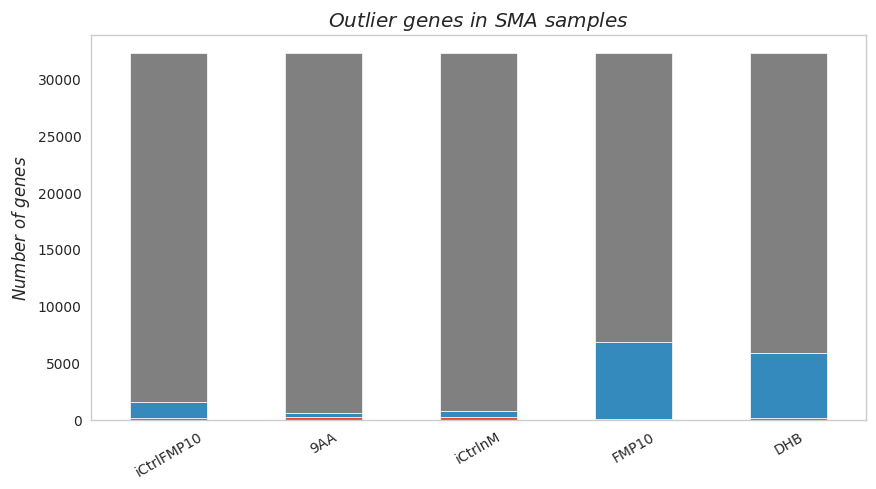

In [34]:
# create stacked bar chart for monthly temperatures
df.plot(kind='bar', stacked=True, color=colors, figsize=(10, 5))
plt.title(r'$Outlier\ genes\ in\ SMA\ samples$')
plt.ylabel(r'$Number\ of\ genes$')
plt.xticks(rotation=30)
#dont show legend
plt.legend().set_visible(False)
#save figure as pdf
plt.savefig('outlier_genes_combined.pdf', bbox_inches='tight')

In [35]:
#get % of upregulated genes, downregulated genes and not significant genes
sample_props = dict()
for row in df.iterrows():
    name, r = row[0], row[1]
    n = r.sum()

    upreg_prop = round(r.Upregulated / n,3) * 100
    downreg_prop = round(r.Downregulated / n, 3) * 100
    not_significant_prop = round(r['No significance'] / n, 3) * 100

    sample_props[name] = {"Upregulated(%)" : upreg_prop, "Downregulated(%)": downreg_prop, "Not significat(%)": not_significant_prop}


In [40]:
sample_props

{'iCtrlFMP10': {'Upregulated(%)': 0.4,
  'Downregulated(%)': 4.3,
  'Not significat(%)': 95.3},
 '9AA': {'Upregulated(%)': 0.8999999999999999,
  'Downregulated(%)': 0.8999999999999999,
  'Not significat(%)': 98.2},
 'iCtrlnM': {'Upregulated(%)': 0.8,
  'Downregulated(%)': 1.6,
  'Not significat(%)': 97.6},
 'FMP10': {'Upregulated(%)': 0.2,
  'Downregulated(%)': 21.0,
  'Not significat(%)': 78.8},
 'DHB': {'Upregulated(%)': 0.4,
  'Downregulated(%)': 17.9,
  'Not significat(%)': 81.69999999999999}}

In [36]:
def getlgfold(x,k=0.25):
    return k + x

upregulated_list = []
downregulated_list = []
not_significant_list = []
samples_list = []
for i, sma_sample in enumerate(sma_expression.keys()):
    expression_sma = sma_expression[sma_sample]

    downregulated = (k + expression_sma < expression_visium).sum()
    downregulated_list.append(downregulated)
    upregulated = (k + expression_visium < expression_sma).sum()
    upregulated_list.append(upregulated)
    not_significant_list.append(len(expression_visium) - (upregulated + downregulated))
    samples_list.append(sma_sample)

In [37]:
df = pd.DataFrame({'Upregulated': upregulated_list,
                   'Downregulated': downregulated_list,
                   'No significance': not_significant_list},
                  index=samples_list)

In [38]:
colors = ['C0', 'C1', '#808080']

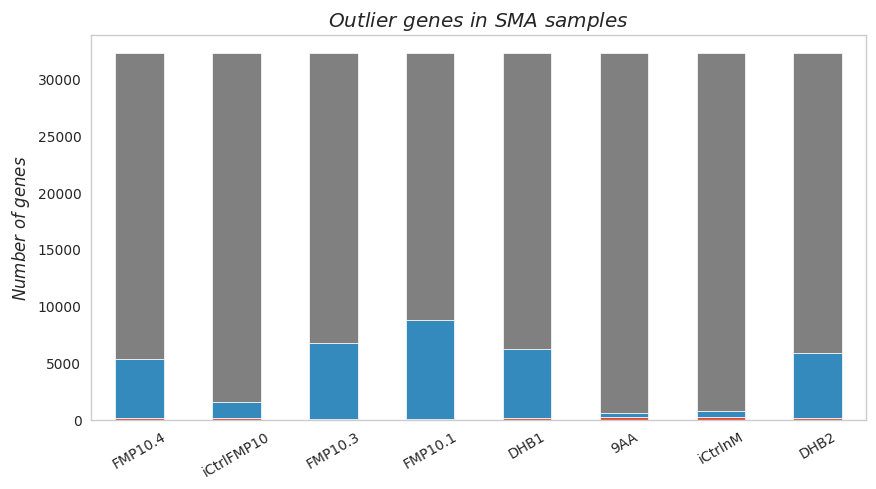

In [39]:
# create stacked bar chart for monthly temperatures
df.plot(kind='bar', stacked=True, color=colors, figsize=(10, 5))
plt.title(r'$Outlier\ genes\ in\ SMA\ samples$')
plt.ylabel(r'$Number\ of\ genes$')
#rotate x axis labels
plt.xticks(rotation=30)
plt.legend().set_visible(False)
plt.savefig('outlier_genes_all.pdf', bbox_inches='tight')